# Notebook to inspect, debug and compare studies

In [2]:
import optuna
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.optimize import linear_sum_assignment


# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
#from lib.sklearn_clusterer import SklearnClusterer
import lib.sklearn_clusterer as sklcl
from lib.focal import FocalH
from lib.base_nn import Data
from lib import metrics# import count_clusters, count_labels, compute_score, total, separation_efficiency
from lib.misc_util import open_bundle

os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

In [6]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P5_N100.root"

study_kmeans_file = "studies/best/study_kmeans_tiny_many_14092025_140415.pkl"
study_kmeans = open_bundle(study_kmeans_file)

study_gauss_file = "studies/best/study_gauss_tiny_many_14092025_151623.pkl"
study_gauss = open_bundle(study_gauss_file)

study_ma_file = "studies/best/study_ma_tiny_single_sep_13092025_203818.pkl"
study_ma = open_bundle(study_ma_file)

study_hdbscan_file = "studies/best/study_hdbscan_08092025_175702.pkl"
study_hdbscan = open_bundle(study_hdbscan_file)

study_cnn_file = "studies/best/study_cnn_01092025_153611.pkl"
study_cnn = open_bundle(study_cnn_file)


In [3]:
def get_study(filename):
    with open(filename, "rb") as f:
        loaded_bundle = pickle.load(f)
    return loaded_bundle
    
kmeans_study = open_bundle("studies/best/kmeans/"+"study_kmeans_train_tiny_sep_100.pkl")
ma_study = open_bundle("studies/best/ma/"+"study_ma_train_tiny_sep_100.pkl")
gmm_study = open_bundle("studies/best/gmm/"+"study_gauss_train_tiny_sep_100.pkl")
dbscan_study = open_bundle("studies/best/dbscan/"+"study_dbscan_train_tiny_sep_100.pkl")
hdbscan_study = open_bundle("studies/best/hdbscan/"+"study_hdbscan_train_tiny_sep_100.pkl")
affinity_propagation_study = open_bundle("studies/best/affinity_propagation/"+"study_affinity_propagation_train_tiny_sep_100.pkl")
agglomerative_study = open_bundle("studies/best/agglomerative/"+"study_agglomerative_train_tiny_sep_100.pkl")
birch_study = open_bundle("studies/best/birch/"+"study_birch_train_tiny_sep_100.pkl")
optics_study = open_bundle("studies/best/optics/"+"study_optics_train_tiny_sep_100.pkl")
spectral_study = open_bundle("studies/best/spectral/"+"study_spectral_train_tiny_sep_100.pkl")
cnn_study = open_bundle("studies/best/cnn/"+"study_cnn_train_tiny_sep_100.pkl")


In [4]:
def plot_transformed(X, ax):
    ax.scatter(X[:,0], X[:,1], s=2, color="black")

def plot_transformed_clustered(X, Y, ax):
    for l in set(Y):
        if l == 0:
            continue
        mask = Y == l
        ax.scatter(X[mask][:,0], X[mask][:,1], s=2)


def plot_clustering(filename, event, study, ax):
    """
    Debug matrix
    """

    try:
        ax = ax.flatten()
    except AttributeError:
        pass
    
    tfile = ROOT.TFile(filename, "READ")
    ttree = tfile.Get("EventsTree")
    ttree.GetEntry(event)

    iadj = np.load("p2_sim_adj_map2.npy")
    npvals = np.array(ttree.value, dtype=np.float32)

    
    foc = FocalH()
    foc.heatmap_mono(npvals[iadj], ax[0], "grey_r")

    if study["method"]["name"] in ["ma"]:
        foc.heatmap_labels(ttree, event, ax[2])
        clus = ModifiedAggregationClusterer()
        d = clus.cluster_debug(filename, ttree, event, study["method"], study["study"].best_params)
        foc.heatmap(d["values"][iadj], d["tags"][iadj], ax[1])
        #ax[1].axis("off")
        #ax[2].axis("off")
        
    elif study["method"]["name"] in ["cnn"]:
        foc.heatmap_labels(ttree, event, ax[4])
        clus = UNetClusterer()
        d = clus.cluster_debug(filename, ttree, event, study, study["study"].best_params)
        ax[1].imshow(d["event"].squeeze().squeeze().detach().numpy(), cmap="grey_r")
        ax[2].imshow(d["output"].squeeze().squeeze().detach().numpy(), cmap="grey_r")
        foc.heatmap(d["values"][iadj], d["tags"][iadj], ax[3])
        
    elif study["method"]["name"] in ["hdbscan", "dbscan", "kmeans", "gauss", "birch", "agglomerative", "optics", "affinity_propagation", "spectral"]:
        foc.heatmap_labels(ttree, event, ax[4])
        clus = sklcl.SklearnClusterer()
        d = clus.cluster_debug(filename, ttree, event, study["method"], study["study"].best_params)
        plot_transformed(d["X"], ax[1])
        plot_transformed_clustered(d["X"], d["Y"], ax[2])
        foc.heatmap(d["values"][iadj], d["tags"][iadj], ax[3])
        ax[1].set_xlim(-19.5/2,19.5/2)
        ax[1].set_ylim(-19.5/2,19.5/2)
        ax[1].set_aspect("equal")
        ax[2].set_xlim(-19.5/2,19.5/2)
        ax[2].set_ylim(-19.5/2,19.5/2)
        ax[2].set_aspect("equal")

    for a in ax:
        a.axis("off")
        a.set_xticks([])
        a.set_yticks([])
        pass

    fig.tight_layout()
    
    pass




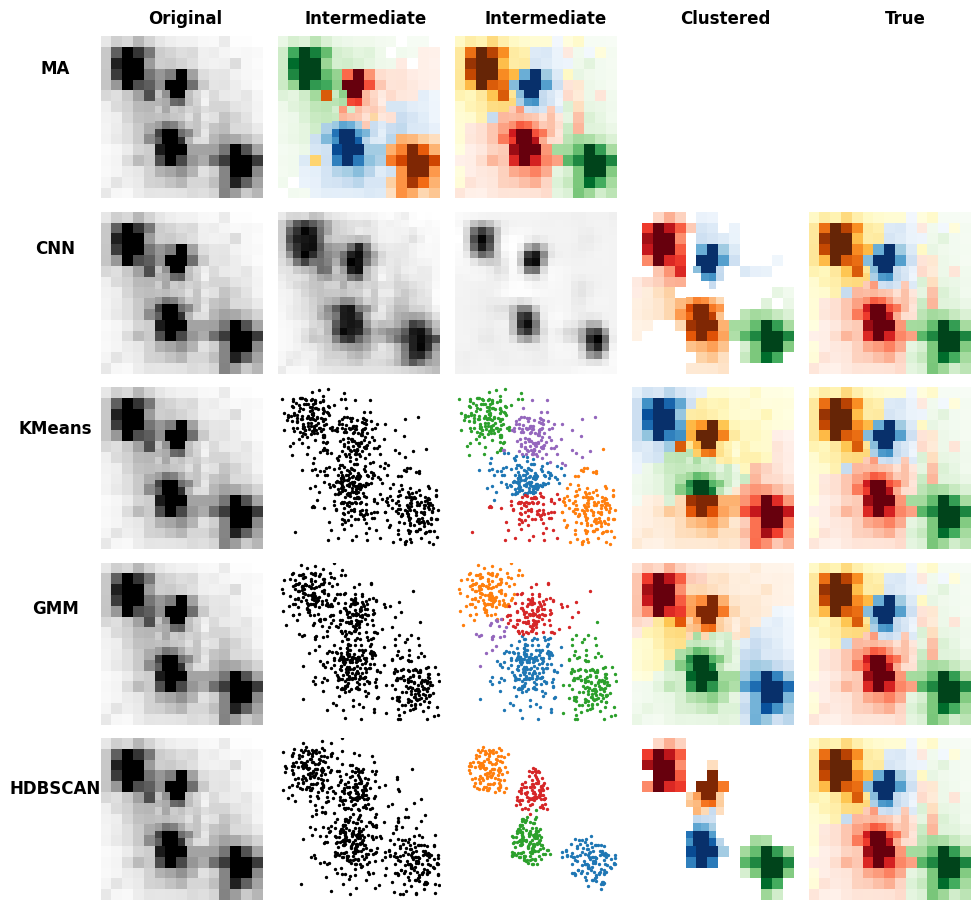

In [8]:
event=20
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Define row and column labels
row_labels = ["MA", "CNN", "KMeans", "GMM", "HDBSCAN"]
column_labels = ["Original", "Intermediate", "Intermediate", "Clustered", "True"]

# Create the figure and subplots
rows, cols = 5, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, ma_study, ax[0])
plot_clustering(filename, event, cnn_study, ax[1])
plot_clustering(filename, event, kmeans_study, ax[2])
plot_clustering(filename, event, gmm_study, ax[3])
plot_clustering(filename, event, hdbscan_study, ax[4])

# Add row labels (left side)
for i, label in enumerate(row_labels):
    fig.text(
        0.02,  # x position (left margin)
        0.9 - i * 0.18,  # y position (adjust based on number of rows)
        label,
        va="center",
        ha="center",
        fontsize=12,
        fontweight="bold",
    )

# Add column labels (top side)
for j, label in enumerate(column_labels):
    fig.text(
        0.15 + j * 0.18,  # x position (adjust based on number of columns)
        0.95,  # y position (top margin)
        label,
        va="center",
        ha="center",
        fontsize=12,
        fontweight="bold",
    )

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust rect to make space for labels
plt.show()

fig.savefig("debug_matrix.png", bbox_inches="tight")


Plot heatmap without colors -> (plot original points (heatmapped?)) -> plot transformed -> plot clustered -> plot mapped -> plot tru

# Examples for thesis

## MA

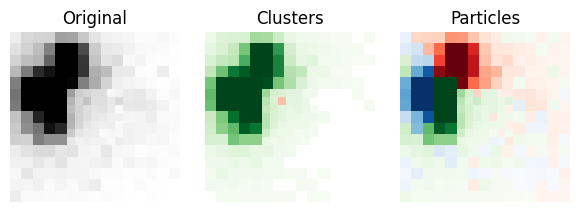

In [48]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P3_N100.root"
event=52
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, ma_study, ax)



ax[2].set_title("Particles")
ax[1].set_title("Clusters")
ax[0].set_title("Original")
fig.savefig("ma_examples.png", bbox_inches="tight")
#ax[2].set_title("")

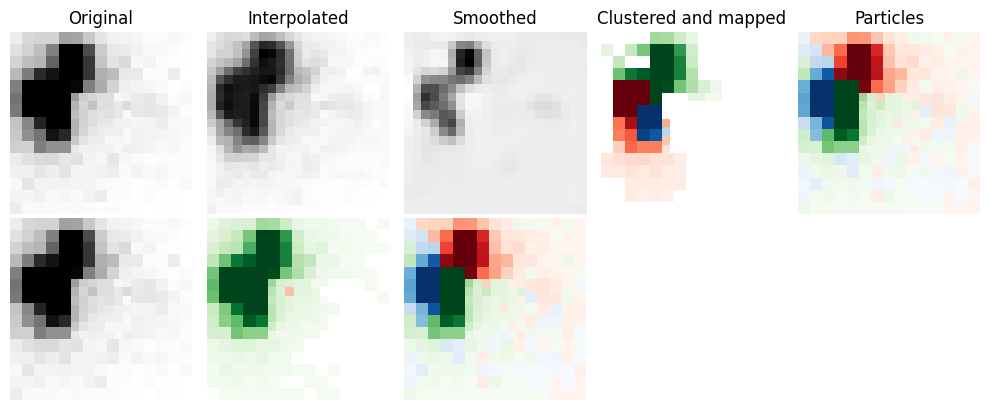

In [52]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P3_N100.root"
event=52
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, cnn_study, ax)

ax[4].set_title("Particles")
ax[3].set_title("Clustered and mapped")
ax[2].set_title("Smoothed")
ax[1].set_title("Interpolated")
ax[0].set_title("Original")
fig.savefig("cnn_examples.png", bbox_inches="tight")


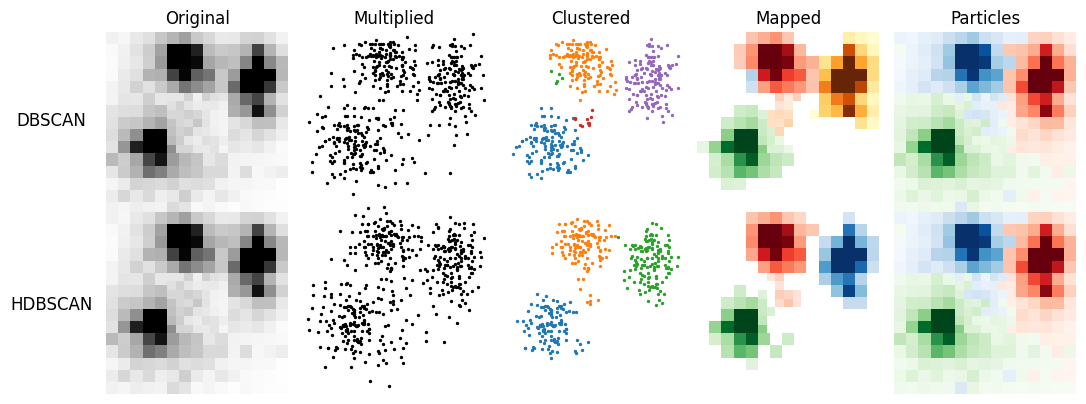

In [19]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P3_N100.root"
event=6
event=73
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 2, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, dbscan_study, ax[0])
plot_clustering(filename, event, hdbscan_study, ax[1])
#plot_clustering(filename, event, optics_study, ax[2])

fig.text(-0.04, 0.73, "DBSCAN", va="center", ha="center", fontsize=12)
fig.text(-0.04, 0.27, "HDBSCAN", va="center", ha="center", fontsize=12)
#fig.text(-0.04, 0.18, "OPTICS", va="center", ha="center", fontsize=12)


ax[0][4].set_title("Particles")
ax[0][3].set_title("Mapped")
ax[0][2].set_title("Clustered")
ax[0][1].set_title("Multiplied")
ax[0][0].set_title("Original")

fig.savefig("density_based_examples.png", bbox_inches="tight")

/home/bjartur/workspace/anaconda3/envs/focalh/lib/python3.12/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


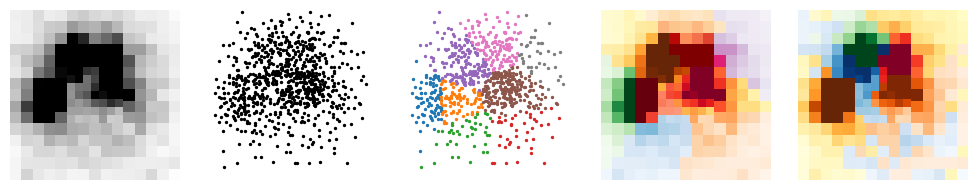

In [36]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P6_N100.root"
event=5
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, affinity_propagation_study, ax)
fig.savefig("affinity_examples.png", bbox_inches="tight")

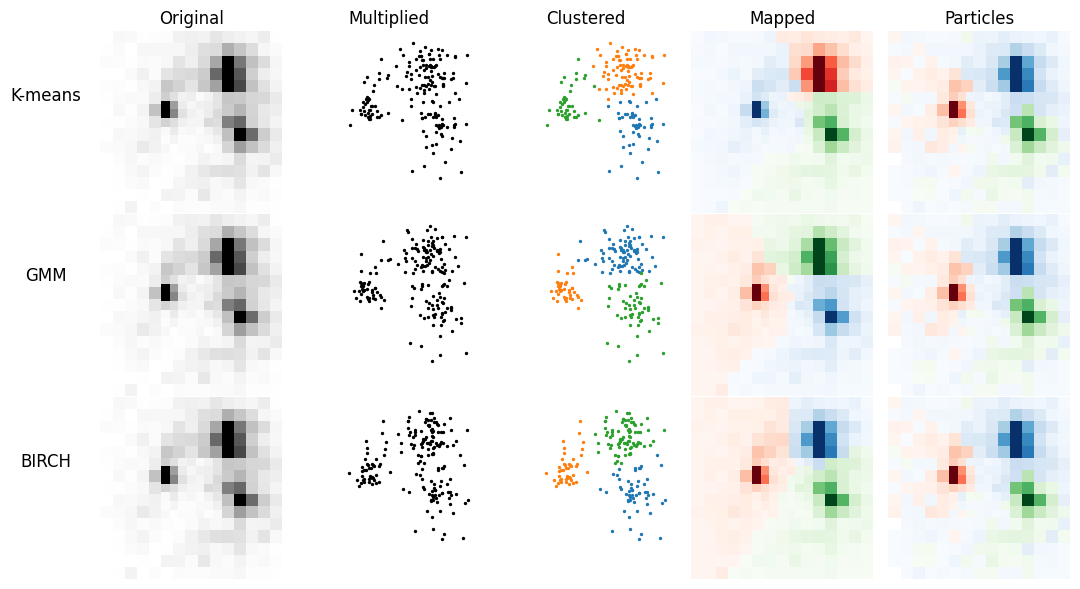

In [25]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E200_P3_N100.root"
event=42  #51
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 3, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, kmeans_study, ax[0])
plot_clustering(filename, event, gmm_study, ax[1])
plot_clustering(filename, event, birch_study, ax[2])


fig.text(-0.04, 0.85, "K-means", va="center", ha="center", fontsize=12)
fig.text(-0.04, 0.55, "GMM", va="center", ha="center", fontsize=12)
fig.text(-0.04, 0.24, "BIRCH", va="center", ha="center", fontsize=12)

ax[0][4].set_title("Particles")
ax[0][3].set_title("Mapped")
ax[0][2].set_title("Clustered")
ax[0][1].set_title("Multiplied")
ax[0][0].set_title("Original")


fig.savefig("kmeans_gmm_birch_examples.png", bbox_inches="tight")


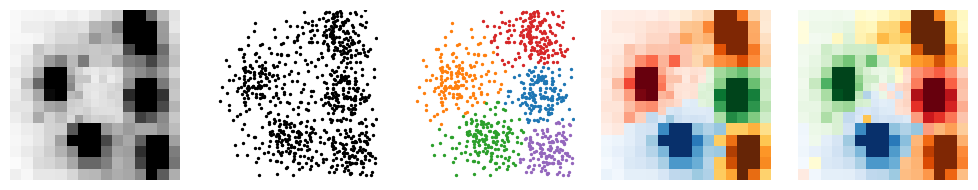

In [88]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P5_N100.root"
event=10
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, gmm_study, ax)
fig.savefig("gmm_examples.png", bbox_inches="tight")


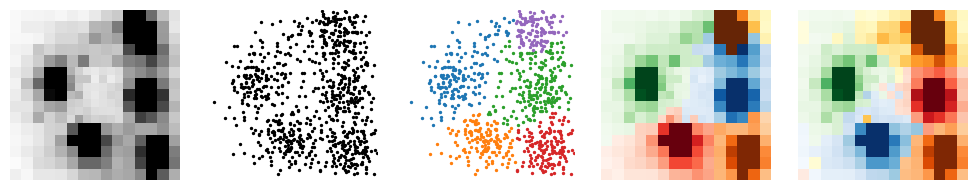

In [89]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P5_N100.root"
event=10
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, birch_study, ax)
fig.savefig("birch_examples.png", bbox_inches="tight")


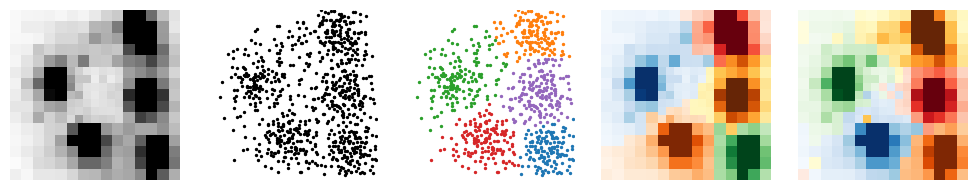

In [90]:
filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P5_N100.root"
event=10
            # EVAL_E350_P2_N100 event 50 is interesting
            # 55 EVAL_E350_P5_N100

# Create the figure and subplots
rows, cols = 1, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2))

# Plot the clustering results for each method
plot_clustering(filename, event, spectral_study, ax)
fig.savefig("spectral_examples.png", bbox_inches="tight")
